In [64]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time
import random

%matplotlib inline

In [65]:
vehicle_images_original = car_images = glob.glob('C:\\Users\\Kuntal\\Desktop\\Udacity\\vehicles\\**\\*.png')
non_vehicle_images_original = noncar_images = glob.glob('C:\\Users\\Kuntal\\Desktop\\Udacity\\non-vehicles\\**\\*.png')
print('Number of Images with Car -',len(car_images), '\n\nNumber of Images which do not have a Car -',len(noncar_images))

Number of Images with Car - 8792 

Number of Images which do not have a Car - 8968


# Visualizing the Data

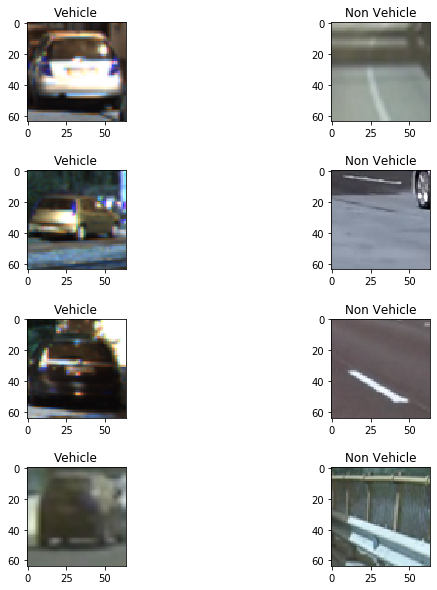

In [66]:
f, axes = plt.subplots(4,2, figsize=(10,10))
plt.subplots_adjust(hspace=0.5)

for index in range(4):
    vehicle=random.randint(0, len(car_images)-1)
    non_vehicle=random.randint(0, len(noncar_images)-1)
    car_img = cv2.imread(car_images[vehicle])
    noncar_img = cv2.imread(noncar_images[non_vehicle])
    axes[index,0].imshow(car_img)
    axes[index,0].set_title("Vehicle")
    axes[index,1].imshow(noncar_img)
    axes[index,1].set_title("Non Vehicle")

In [4]:
### Extract Color Space

#creating a Histogram
def ExtractColorHistogram(image, nbins=32, bins_range=(0,255), resize=None):
    if(resize !=None):
        image= cv2.resize(image, resize)
    zero_channel= np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    first_channel= np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    second_channel= np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    return zero_channel,first_channel, second_channel

#Find Center of the bin edges
def FindBinCenter(histogram_channel):
    bin_edges = histogram_channel[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    return bin_centers

#Extracting Color Features from bin lengths
def ExtractColorFeatures(zero_channel, first_channel, second_channel):
    return np.concatenate((zero_channel[0], first_channel[0], second_channel[0]))

No of features are 384


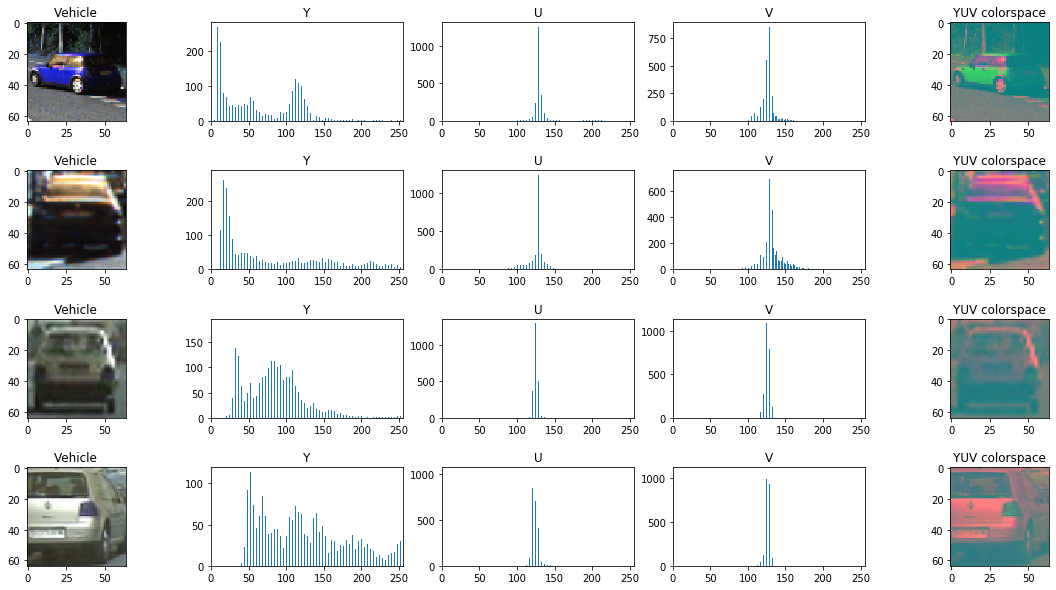

In [68]:
f, axes= plt.subplots(4,5, figsize=(20,10))
f.subplots_adjust(hspace=0.5)

for index in range(4):
    
    vehicle=random.randint(0, len(vehicle_images_original)-1)
    non_vehicle=random.randint(0, len(non_vehicle_images_original)-1)
    
    coloredImage= cv2.cvtColor(cv2.imread(vehicle_images_original[vehicle]),cv2.COLOR_RGB2YUV)
    r,g,b = ExtractColorHistogram(coloredImage,128)
   
    center= FindBinCenter(r)
    axes[index,0].imshow(cv2.imread(vehicle_images_original[vehicle]))
    axes[index,0].set_title("Vehicle")
    axes[index,1].set_xlim(0,256)
    axes[index,1].bar(center,r[0])
    axes[index,1].set_title("Y")
    axes[index,2].set_xlim(0,256)
    axes[index,2].bar(center,g[0])
    axes[index,2].set_title("U")
    axes[index,3].set_xlim(0,256)
    axes[index,3].bar(center,b[0])
    axes[index,3].set_title("V")
    axes[index,4].imshow(coloredImage)
    axes[index,4].set_title("YUV colorspace")
    
features = ExtractColorFeatures(r,g,b)
print("No of features are "+ str(len(features)))

In [14]:
#Resizing Image to extract features, so as to reduce the feature vector size
def SpatialBinningFeatures(image,size):
    image= cv2.resize(image,size)
    return image.ravel()

In [17]:
#testing the spatial binning

featureList=SpatialBinningFeatures(cv2.imread(vehicle_images_original[1]),(16,16))
print("No of features before spatial binning",len(cv2.imread(vehicle_images_original[1]).ravel()))
print("No of features after spatial binning",len(featureList))

No of features before spatial binning 12288
No of features after spatial binning 768


# Image Feature Extraction - Histogram of Features

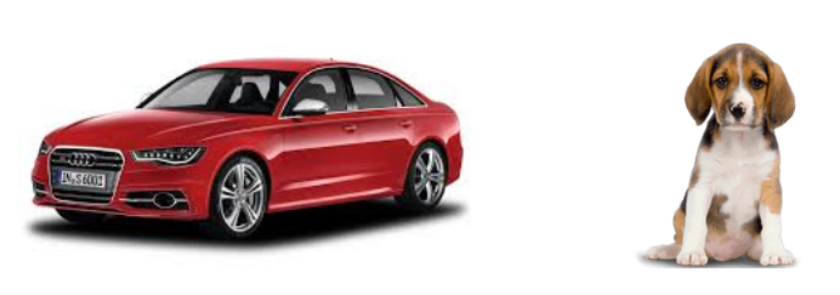
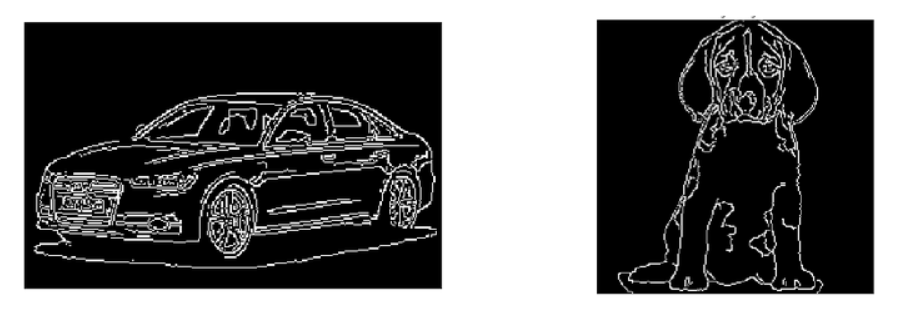

The HOG descriptor focuses on the structure or the shape of an object. HOG is able to provide the edge direction as well. This is done by extracting the gradient and orientation (or you can say magnitude and direction) of the edges.

Additionally, these orientations are calculated in ‘localized’ portions. This means that the complete image is broken down into smaller regions and for each region, the gradients and orientation are calculated.

Finally the HOG would generate a Histogram for each of these regions separately. The histograms are created using the gradients and orientations of the pixel values, hence the name ‘Histogram of Oriented Gradients’.

**The HOG feature descriptor counts the occurrences of gradient orientation in localized portions of an image.**

In [18]:
def GetFeaturesFromHog(image,orient,cellsPerBlock,pixelsPerCell, visualise= False, feature_vector_flag=True):
    if(visualise==True):
        hog_features, hog_image = hog(image, orientations=orient,
                          pixels_per_cell=(pixelsPerCell, pixelsPerCell), 
                          cells_per_block=(cellsPerBlock, cellsPerBlock), 
                          visualise=True, feature_vector=feature_vector_flag)
        return hog_features, hog_image
    else:
        hog_features = hog(image, orientations=orient,
                          pixels_per_cell=(pixelsPerCell, pixelsPerCell), 
                          cells_per_block=(cellsPerBlock, cellsPerBlock), 
                          visualise=False, feature_vector=feature_vector_flag)
        return hog_features

Feature Vector Length Returned is  324
No of features that can be extracted from image  4096


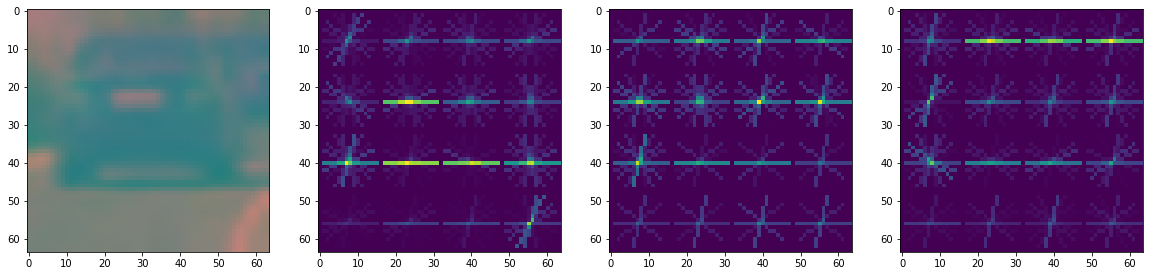

In [69]:
#testing HOG on test images

image=cv2.imread(vehicle_images_original[1])
image= cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
image_channel_0=image[:,:,0]
image_channel_1=image[:,:,1]
image_channel_2=image[:,:,2]

feature_0,hog_img_0=GetFeaturesFromHog(image_channel_0,9,2,16,visualise=True,feature_vector_flag=True)
feature_1,hog_img_1=GetFeaturesFromHog(image_channel_1,9,2,16,visualise=True,feature_vector_flag=True)
feature_2,hog_img_2=GetFeaturesFromHog(image_channel_2,9,2,16,visualise=True,feature_vector_flag=True)

f, axes= plt.subplots(1,4,figsize=(20,10))
axes[0].imshow(image)
axes[1].imshow(hog_img_0)
axes[2].imshow(hog_img_1)
axes[3].imshow(hog_img_2)


print("Feature Vector Length Returned is ",len(feature_0))
print("No of features that can be extracted from image ",len(hog_img_0.ravel()))

## Extracting Features drom the Image Dataset

In [22]:
def ConvertImageColorspace(image, colorspace):
    return cv2.cvtColor(image, colorspace)

In [43]:
def ExtractFeatures(images,orientation,cellsPerBlock,pixelsPerCell, convertColorspace=False):
    featureList=[]
    imageList=[]
    for image in images:
        if(convertColorspace==True):
            #image = cv2.imread(image)
            image= cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        local_features_1=GetFeaturesFromHog(image[:,:,0],orientation,cellsPerBlock,pixelsPerCell, False, True)
        local_features_2=GetFeaturesFromHog(image[:,:,1],orientation,cellsPerBlock,pixelsPerCell, False, True)
        local_features_3=GetFeaturesFromHog(image[:,:,2],orientation,cellsPerBlock,pixelsPerCell, False, True)
        x=np.hstack((local_features_1,local_features_2,local_features_3))
        featureList.append(x)
    return featureList

In [25]:
%%time

orientations=9
cellsPerBlock=2
pixelsPerBlock=16
convertColorSpace=True
vehicleFeatures= ExtractFeatures(vehicle_images_original,orientations,cellsPerBlock,pixelsPerBlock, convertColorSpace)
nonVehicleFeatures= ExtractFeatures(non_vehicle_images_original,orientations,cellsPerBlock,pixelsPerBlock, convertColorSpace)

In [26]:
featuresList= np.vstack([vehicleFeatures, nonVehicleFeatures])
print("Shape of features list is ", featuresList.shape)
labelList= np.concatenate([np.ones(len(vehicleFeatures)), np.zeros(len(nonVehicleFeatures))])
print("Shape of label list is ", labelList.shape)

Shape of features list is  (17760, 972)
Shape of label list is  (17760,)


In [ ]:
##

In [27]:
# train test split of data

from sklearn.model_selection import train_test_split

X_train,  X_test,Y_train, Y_test = train_test_split(featuresList, labelList, test_size=0.2, shuffle=True)

In [28]:
# normalization and scaling

from sklearn.preprocessing import StandardScaler

scaler= StandardScaler()
scaler.fit(X_train)
X_train_scaled= scaler.transform(X_train)
X_test_scaled= scaler.transform(X_test)

In [29]:
%%time

# Train a Linear SVM classifer
from sklearn.svm import LinearSVC
classifier1= LinearSVC()
classifier1.fit(X_train,Y_train)
print("Accuracy of SVC is  ", classifier1.score(X_test,Y_test) )

Accuracy of SVC is   0.9887387387387387
Wall time: 1.44 s


In [30]:
# function to draw sliding Windows

import matplotlib.image as mpimg

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    
    for bbox in bboxes:
        r=random.randint(0,255)
        g=random.randint(0,255)
        b=random.randint(0,255)
        color=(r, g, b)
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [31]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.9, 0.9)):
   
    if x_start_stop[0] == None:
        x_start_stop[0]=0
    if x_start_stop[1] == None:
        x_start_stop[1]=img.shape[1]
    if y_start_stop[0] ==  None:
        y_start_stop[0]= 0
    if y_start_stop[1] ==  None:
        y_start_stop[1]=img.shape[0]
    
    
    window_list = []
    image_width_x= x_start_stop[1] - x_start_stop[0]
    image_width_y= y_start_stop[1] - y_start_stop[0]
     
    windows_x = np.int( 1 + (image_width_x - xy_window[0])/(xy_window[0] * xy_overlap[0]))
    windows_y = np.int( 1 + (image_width_y - xy_window[1])/(xy_window[1] * xy_overlap[1]))
    
    modified_window_size= xy_window
    for i in range(0,windows_y):
        y_start = y_start_stop[0] + np.int( i * modified_window_size[1] * xy_overlap[1])
        for j in range(0,windows_x):
            x_start = x_start_stop[0] + np.int( j * modified_window_size[0] * xy_overlap[0])
            
            x1 = np.int( x_start +  modified_window_size[0])
            y1= np.int( y_start + modified_window_size[1])
            window_list.append(((x_start,y_start),(x1,y1)))
    return window_list

In [41]:
# function that returns the refined Windows
# From Refined Windows we mean that the windows where the classifier predicts the output to be a car

def DrawCars(image,windows, converColorspace=False):
    refinedWindows=[]
    
    for window in windows:
        
        start= window[0]
        end= window[1]
        clippedImage=image[start[1]:end[1], start[0]:end[0]]
        
        if(clippedImage.shape[1] == clippedImage.shape[0] and clippedImage.shape[1]!=0):
            
            clippedImage=cv2.resize(clippedImage, (64,64))
            
            f1=ExtractFeatures([clippedImage], 9 , 2 , 16,converColorspace)
        
            predictedOutput=classifier1.predict([f1[0]])
            if(predictedOutput==1):
                refinedWindows.append(window)
        
    return refinedWindows

In [33]:
def DrawCarsOptimised(image, image1, image2,windows, converColorspace=False):
    refinedWindows=[]
    for window in windows:
        
        start= window[0]
        end= window[1]
        clippedImage=image[start[1]:end[1], start[0]:end[0]]
        clippedImage1=image1[start[1]:end[1], start[0]:end[0]]
        clippedImage2=image2[start[1]:end[1], start[0]:end[0]]
        
        if(clippedImage.shape[1] == clippedImage.shape[0] and clippedImage.shape[1]!=0):
            
            clippedImage=cv2.resize(clippedImage, (64,64)).ravel()
            clippedImage1=cv2.resize(clippedImage1, (64,64)).ravel()
            clippedImage2=cv2.resize(clippedImage2, (64,64)).ravel()
            
            #f1=ExtractFeatures([clippedImage], 9 , 2 , 16,converColorspace)
            f1= np.hstack((clippedImage,clippedImage1,clippedImage2))
            f1=scaler.transform(f1.reshape(1,-1))   
            print(f1.shape)
            predictedOutput=classifier1.predict([f1[0]])
            if(predictedOutput==1):
                refinedWindows.append(window)
        
    return refinedWindows

Total No of windows are  470


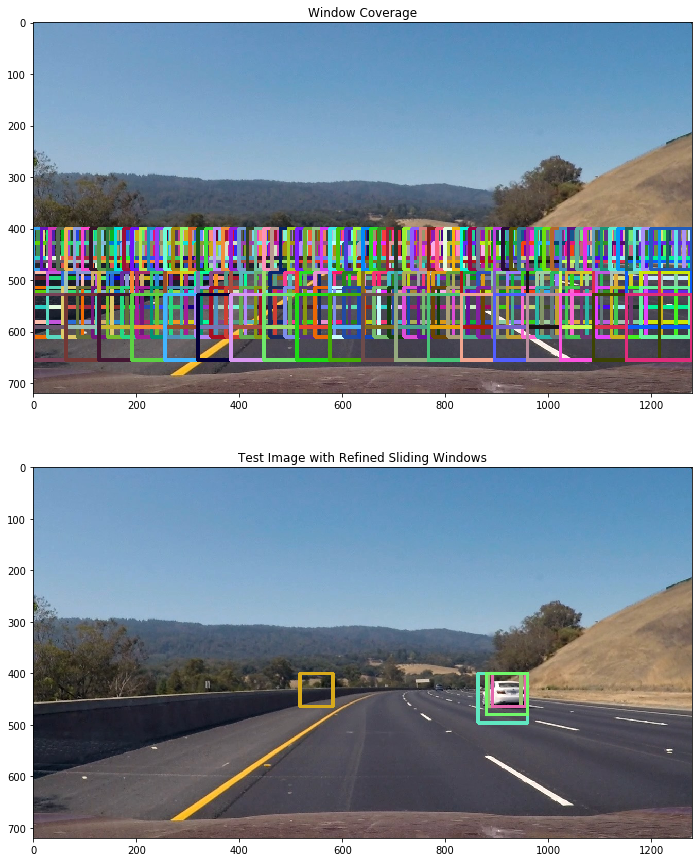

In [44]:
#testing our functions of slide_window and draw window. Defining here dummy windows

image = mpimg.imread('C:\\Users\\Kuntal\\Desktop\\Udacity\\test_images\\test3.jpg')

windows1 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[400,464], 
                    xy_window=(64,64), xy_overlap=(0.15, 0.15))
windows4 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[400,480], 
                    xy_window=(80,80), xy_overlap=(0.2, 0.2))
windows2 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[400,612], 
                    xy_window=(96,96), xy_overlap=(0.3, 0.3))
windows3 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[400,660], 
                    xy_window=(128,128), xy_overlap=(0.5, 0.5))


windows = windows1 + windows2 +  windows3 + windows4
print("Total No of windows are ",len(windows))
refinedWindows=DrawCars(image,windows, True)



f,axes= plt.subplots(2,1, figsize=(30,15))

window_img = draw_boxes(image, windows) 

axes[0].imshow(window_img)
axes[0].set_title("Window Coverage")

window_img = draw_boxes(image, refinedWindows) 

axes[1].set_title("Test Image with Refined Sliding Windows")
axes[1].imshow(window_img)

In [45]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [46]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [47]:
from scipy.ndimage.measurements import label
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

 Number of Cars found -  1


Text(0.5, 1.0, 'Final Image after applying Heat Map')

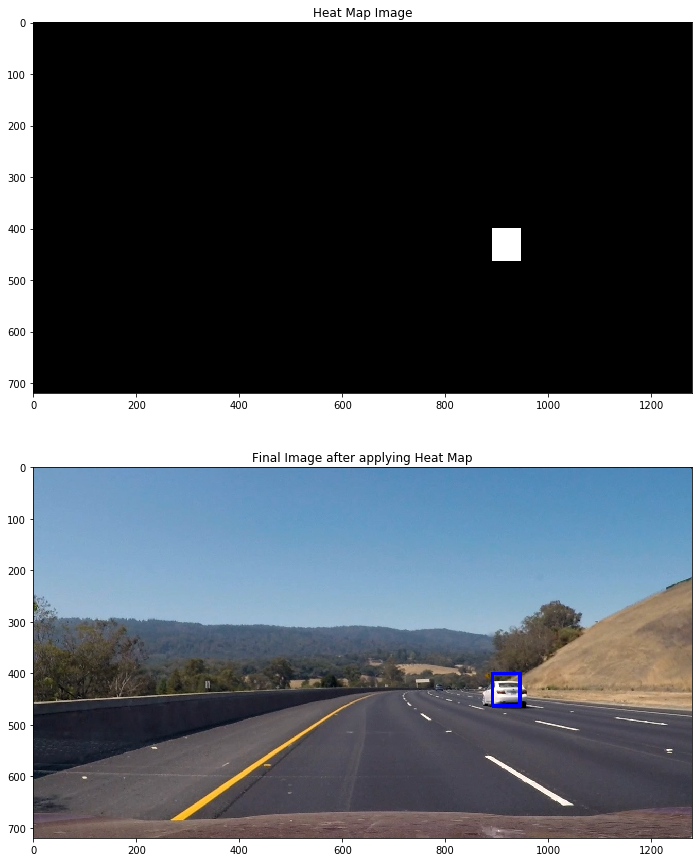

In [48]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)

heat = add_heat(heat,refinedWindows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,3)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

heat_image=heatmap

# Find final boxes from heatmap using label function
labels = label(heatmap)
print(" Number of Cars found - ",labels[1])
draw_img = draw_labeled_bboxes(np.copy(image), labels)

f,axes= plt.subplots(2,1, figsize=(30,15))
axes[0].imshow(heat_image,cmap='gray')
axes[0].set_title("Heat Map Image")
axes[1].imshow(draw_img)
axes[1].set_title("Final Image after applying Heat Map")

In [49]:
class KeepTrack():
    def __init__(self):
        self.refinedWindows = [] 
        
    def AddWindows(self, refinedWindow):
        self.refinedWindows.append(refinedWindow)
        frameHistory=15
        if len(self.refinedWindows) > frameHistory:
            self.refinedWindows = self.refinedWindows[len(self.refinedWindows)-frameHistory:]

In [58]:

orientation=9 # No of orientations of HOG
cellsPerBlock=2 # No of cells per block
pixelsPerCell=16 # No of pixels per cell
xy_window=(64, 64) # window Size
xy_overlap=(0.15, 0.15) # Window Overlap. Please note this is different as provided by Udacity. Overlap of 0.15 means my windows are 85% overlapping with each other
x_start_stop=[0, image.shape[1]] # X Coordinates to start and stop search
y_start_stop=[400, 660] # Y Coordinates to start and stop search

# Window 1- Size - 64x64 , Overlap-85%
windows_normal = slide_window(image, x_start_stop, [400,464], 
                    xy_window, xy_overlap)

# Window 2- Size - 80x80 , Overlap-80%
xy_window_1_25= (80,80)
xy_window_1_25_overlap=(0.2, 0.2)    
windows_1_25 = slide_window(image, x_start_stop, [400,480], 
                    xy_window_1_25, xy_window_1_25_overlap)

# Window 3- Size - 96x96 , Overlap-70%
xy_window_1_5= (96,96)
xy_window_1_5_overlap=(0.3, 0.3)    
windows_1_5 = slide_window(image, x_start_stop, [400,612], 
                    xy_window_1_5, xy_window_1_5_overlap)

# Window 4- Size - 128x128 , Overlap-50%
xy_window_twice_overlap=(0.5, 0.5)    
xy_window_twice = (128,128)
windows_twice = slide_window(image, x_start_stop, [400,660], 
                    xy_window_twice, xy_window_twice_overlap)

# Total Windows - 470
windows= windows_normal +  windows_1_5  + windows_twice +windows_1_25
print("No of Windows are ",len(windows))

No of Windows are  470


In [56]:
# Defining a pipeline for Video Frame Processing
# Note here the track of last 15 frames is kept

def Pipeline(image):
#     features,hog_image=GetFeaturesFromHog(image[:,:,0],orientation,cellsPerBlock,pixelsPerCell, visualise= True, feature_vector_flag=False)
#     features1,hog_image1=GetFeaturesFromHog(image[:,:,1],orientation,cellsPerBlock,pixelsPerCell, visualise= True, feature_vector_flag=False)
#     features2,hog_image2=GetFeaturesFromHog(image[:,:,2],orientation,cellsPerBlock,pixelsPerCell, visualise= True, feature_vector_flag=False)
#     refinedWindows=DrawCarsOptimised(hog_image,hog_image1,hog_image2,windows, True)
    
#     image=find_cars(image, 400, 528, 1,  orientation, pixelsPerCell, cellsPerBlock)
#     image=find_cars(image, 400, 560, 1.25,  orientation, pixelsPerCell, cellsPerBlock)
#     image=find_cars(image, 400, 588, 1.5,  orientation, pixelsPerCell, cellsPerBlock)
#     image=find_cars(image, 400, 660, 2,  orientation, pixelsPerCell, cellsPerBlock)
    rand= random.randint(0,1)
    if(rand<0.4):
        refinedWindows=keepTrack.refinedWindows[:-1]
    else:
        refinedWindows=DrawCars(image,windows, True)
        if len(refinedWindows) > 0:
            keepTrack.AddWindows(refinedWindows)
    
    #refinedWindows=DrawCars(image,windows, True)
#     if len(refinedWindows) > 0:
#         keepTrack.AddWindows(refinedWindows)
            
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    for refinedWindow in keepTrack.refinedWindows:
        heat = add_heat(heat, refinedWindow)
    
    
    
    heatmap = apply_threshold(heat, 25 + len(keepTrack.refinedWindows)//2)
    
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

In [52]:
def PipelineImage(image):

    refinedWindows=DrawCars(image,windows, True)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,refinedWindows)
   
    heatmap = np.clip(heat, 0, 255)
    heatmap = apply_threshold(heat, 4)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img,heatmap

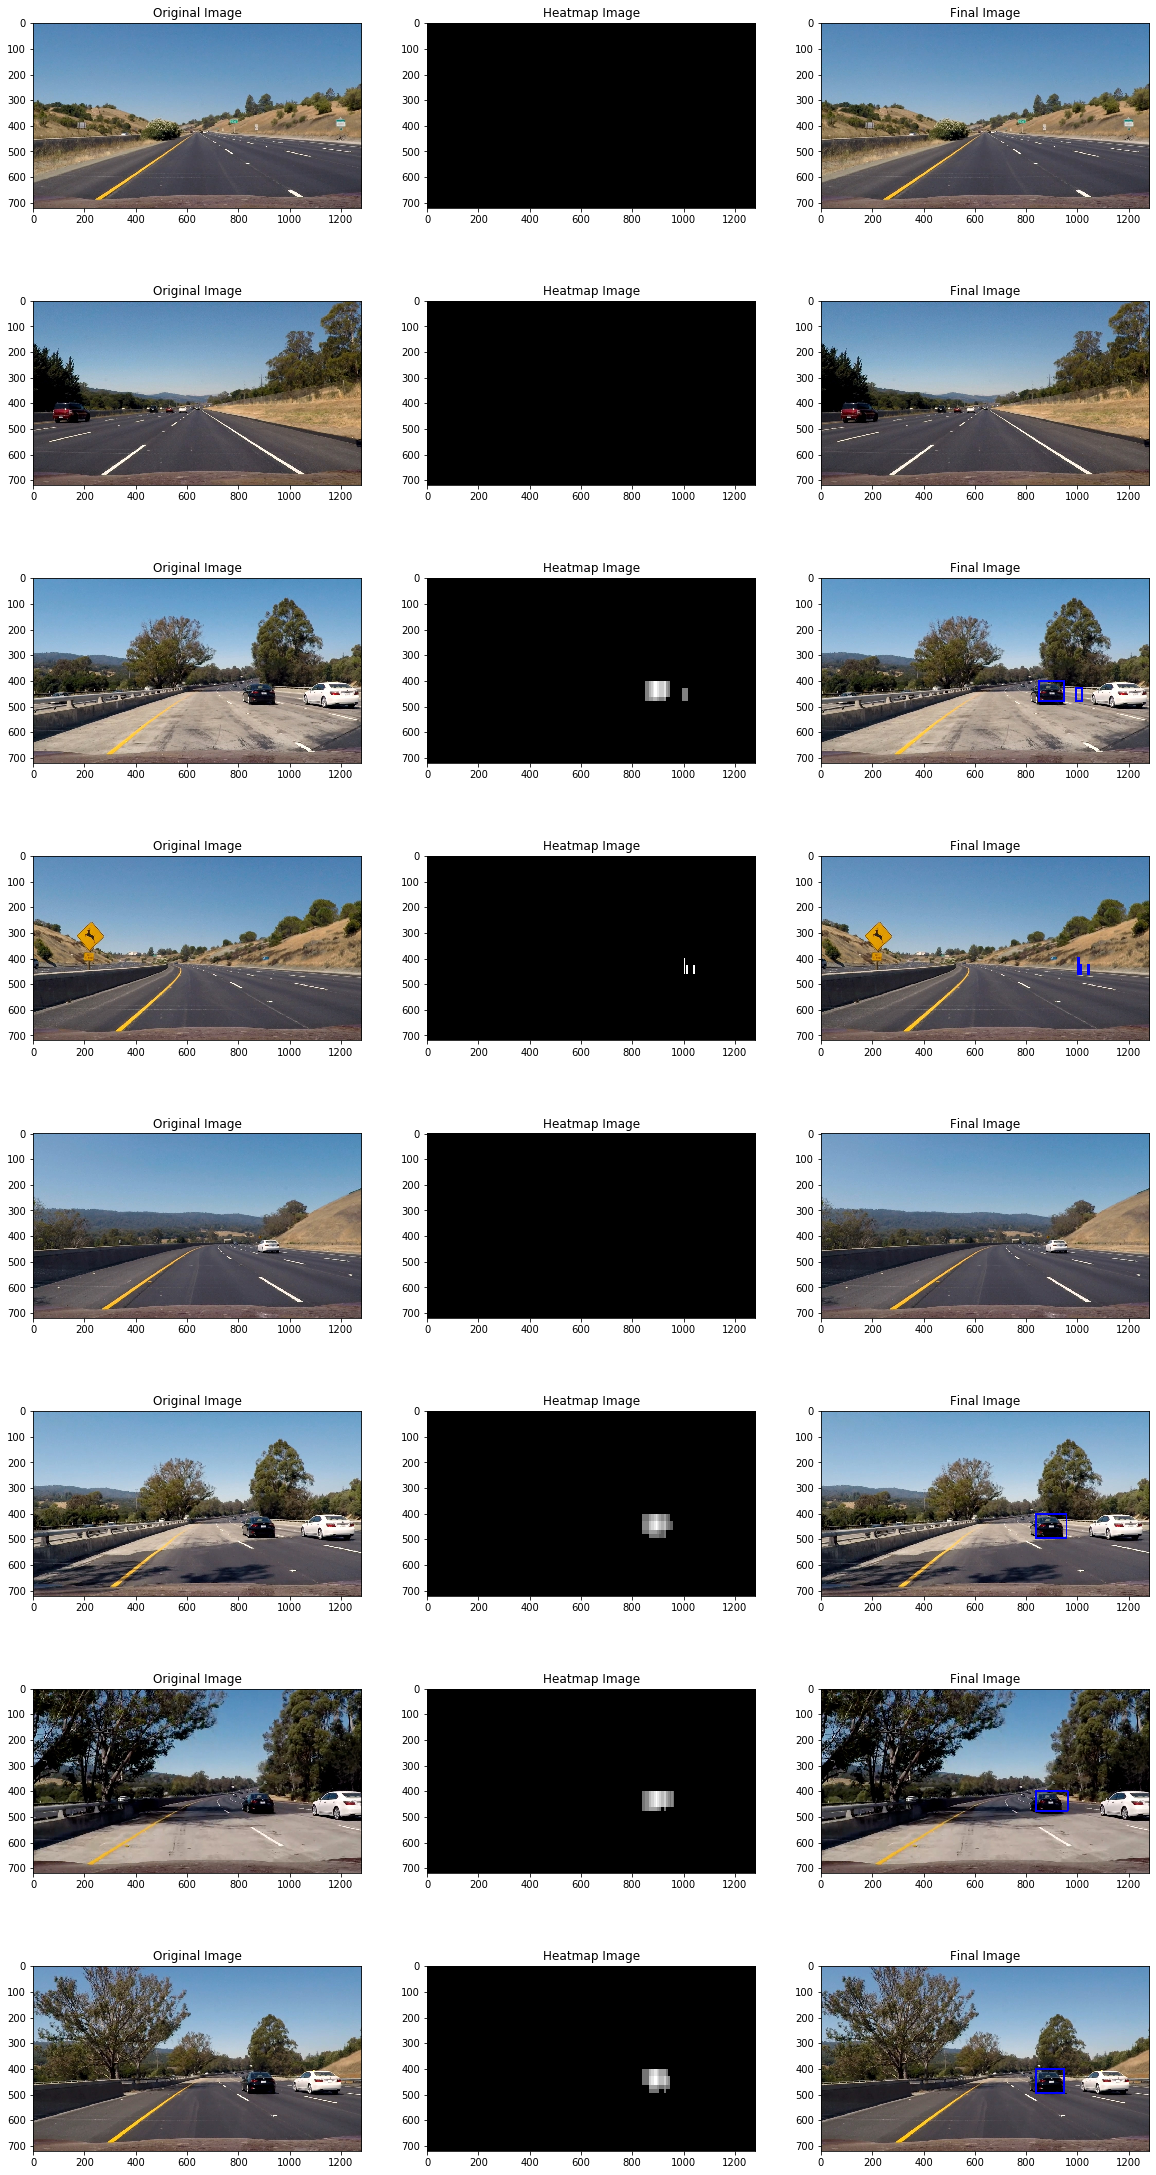

In [59]:
test_images= glob.glob("./test_images/*.jpg")
f, axes= plt.subplots(8,3, figsize=(20,40))

for index,image in enumerate(test_images):
    image = cv2.imread(image)
    
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    finalPic,heatmap = PipelineImage(image)
    axes[index,0].imshow(image)
    axes[index,0].set_title("Original Image")
    axes[index,1].imshow(heatmap,cmap='gray')
    axes[index,1].set_title("Heatmap Image")
    axes[index,2].imshow(finalPic)
    axes[index,2].set_title("Final Image")

In [60]:
keepTrack = KeepTrack()
import moviepy
from moviepy.editor import VideoFileClip
video_output1 = 'full_video_threshold_20_with_frame_skipping_my.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(Pipeline)
%time processed_video.write_videofile(video_output1, audio=False)
video_input1.reader.close()
video_input1.audio.reader.close_proc()

Moviepy - Building video full_video_threshold_20_with_frame_skipping_my.mp4.


Moviepy - Writing video full_video_threshold_20_with_frame_skipping_my.mp4



t:  10%|██████▎                                                           | 120/1260 [01:01<14:26,  1.32it/s, now=None]


t:  21%|█████████████▋                                                    | 261/1260 [02:17<11:20,  1.47it/s, now=None]


t:  30%|███████████████████▋                                              | 376/1260 [03:30<12:40,  1.16it/s, now=None]


t:  40%|██████████████████████████▋                                       | 509/1260 [04:37<08:41,  1.44it/s, now=None]


t:  52%|██████████████████████████████████                                | 650/1260 [05:49<08:26,  1.20it/s, now=None]


t:  62%|█████████████████████████████████████████                         | 785/1260 [06:57<07:24,  1.07it/s, now=None]


t:  72%|███████████████████████████████████████████████▌                  | 909/1260 [08:06<04:41,  1.25it/s, now=None]


t:  83%|█████████████████████████████████████████████████████▋           | 1040/1260 [09:17<01:46,  2.07it/s, now=None]


t:  91%|███████████████████████████████████████████████████████████▎     | 1150/1260 [10:26<01:29,  1.23it/s, now=None]


t: 100%|████████████████████████████████████████████████████████████████▉| 1258/1260 [11:17<00:01,  1.50it/s, now=None]


Moviepy - Done !


Moviepy - video ready full_video_threshold_20_with_frame_skipping_my.mp4


t:  93%|████████████████████████████████████████████████████████████▋    | 1176/1260 [24:31<01:11,  1.18it/s, now=None]

Wall time: 11min 19s
